# Softmax exercise

*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

This exercise is analogous to the SVM exercise. You will:

- implement a fully-vectorized **loss function** for the Softmax classifier
- implement the fully-vectorized expression for its **analytic gradient**
- **check your implementation** with numerical gradient
- use a validation set to **tune the learning rate and regularization** strength
- **optimize** the loss function with **SGD**
- **visualize** the final learned weights


In [1]:
import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

from __future__ import print_function

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [2]:
def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000, num_dev=500):
    """
    Load the CIFAR-10 dataset from disk and perform preprocessing to prepare
    it for the linear classifier. These are the same steps as we used for the
    SVM, but condensed to a single function.  
    """
    # Load the raw CIFAR-10 data
    cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'
    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
    
    # subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]
    mask = np.random.choice(num_training, num_dev, replace=False)
    X_dev = X_train[mask]
    y_dev = y_train[mask]
    
    # Preprocessing: reshape the image data into rows
    X_train = np.reshape(X_train, (X_train.shape[0], -1))
    X_val = np.reshape(X_val, (X_val.shape[0], -1))
    X_test = np.reshape(X_test, (X_test.shape[0], -1))
    X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))
    
    # Normalize the data: subtract the mean image
    mean_image = np.mean(X_train, axis = 0)
    X_train -= mean_image
    X_val -= mean_image
    X_test -= mean_image
    X_dev -= mean_image
    
    # add bias dimension and transform into columns
    X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
    X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
    X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
    X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])
    
    return X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev


# Invoke the above function to get our data.
X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev = get_CIFAR10_data()
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)
print('dev data shape: ', X_dev.shape)
print('dev labels shape: ', y_dev.shape)

Train data shape:  (49000, 3073)
Train labels shape:  (49000,)
Validation data shape:  (1000, 3073)
Validation labels shape:  (1000,)
Test data shape:  (1000, 3073)
Test labels shape:  (1000,)
dev data shape:  (500, 3073)
dev labels shape:  (500,)


## Softmax Classifier

Your code for this section will all be written inside **cs231n/classifiers/softmax.py**. 


In [3]:
# First implement the naive softmax loss function with nested loops.
# Open the file cs231n/classifiers/softmax.py and implement the
# softmax_loss_naive function.

from cs231n.classifiers.softmax import softmax_loss_naive
import time

# Generate a random softmax weight matrix and use it to compute the loss.
W = np.random.randn(3073, 10) * 0.0001
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As a rough sanity check, our loss should be something close to -log(0.1).
print('loss: %f' % loss)
print('sanity check: %f' % (-np.log(0.1)))

loss: 2.412851
sanity check: 2.302585


## Inline Question 1:
Why do we expect our loss to be close to -log(0.1)? Explain briefly.**

**Your answer:** *Fill this in*


In [4]:
# Complete the implementation of softmax_loss_naive and implement a (naive)
# version of the gradient that uses nested loops.
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As we did for the SVM, use numeric gradient checking as a debugging tool.
# The numeric gradient should be close to the analytic gradient.
from cs231n.gradient_check import grad_check_sparse
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

# similar to SVM case, do another gradient check with regularization
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 5e1)
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 5e1)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

numerical: -2.920531 analytic: -2.920531, relative error: 1.721005e-08
numerical: 3.033626 analytic: 3.033626, relative error: 1.621093e-08


numerical: 1.032297 analytic: 1.032297, relative error: 1.019141e-08


numerical: 1.696024 analytic: 1.696024, relative error: 1.073795e-08


numerical: -2.679598 analytic: -2.679598, relative error: 1.410487e-08


numerical: -2.550180 analytic: -2.550180, relative error: 2.123352e-08


numerical: 2.475740 analytic: 2.475740, relative error: 2.544180e-08


numerical: 1.000429 analytic: 1.000429, relative error: 2.227547e-08


numerical: -1.062884 analytic: -1.062883, relative error: 3.849155e-08


numerical: -1.203842 analytic: -1.203842, relative error: 2.153422e-09


numerical: -3.468104 analytic: -3.468104, relative error: 1.173180e-08


numerical: 1.919251 analytic: 1.919251, relative error: 2.967286e-08


numerical: -4.829261 analytic: -4.829261, relative error: 7.704708e-09


numerical: 1.330792 analytic: 1.330792, relative error: 2.433526e-09


numerical: -0.666216 analytic: -0.666216, relative error: 2.831873e-09


numerical: -0.775102 analytic: -0.775102, relative error: 1.851864e-08


numerical: -1.310227 analytic: -1.310227, relative error: 1.083053e-08


numerical: 1.877503 analytic: 1.877503, relative error: 7.237040e-09


numerical: -0.039822 analytic: -0.039822, relative error: 8.260690e-07


numerical: 0.085088 analytic: 0.085088, relative error: 5.748591e-08

In [5]:
# Now that we have a naive implementation of the softmax loss function and its gradient,
# implement a vectorized version in softmax_loss_vectorized.
# The two versions should compute the same results, but the vectorized version should be
# much faster.
tic = time.time()
loss_naive, grad_naive = softmax_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('naive loss: %e computed in %fs' % (loss_naive, toc - tic))

from cs231n.classifiers.softmax import softmax_loss_vectorized
tic = time.time()
loss_vectorized, grad_vectorized = softmax_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic))

# As we did for the SVM, we use the Frobenius norm to compare the two versions
# of the gradient.
grad_difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print('Loss difference: %f' % np.abs(loss_naive - loss_vectorized))
print('Gradient difference: %f' % grad_difference)

naive loss: 2.412851e+00 computed in 0.224998s
vectorized loss: 2.412851e+00 computed in 0.015074s
Loss difference: 0.000000
Gradient difference: 0.000000


iteration 0 / 1500: loss 5.236814
iteration 100 / 1500: loss 4.039552


iteration 200 / 1500: loss 3.601272


iteration 300 / 1500: loss 3.666493


iteration 400 / 1500: loss 3.374906


iteration 500 / 1500: loss 3.117065


iteration 600 / 1500: loss 3.167597


iteration 700 / 1500: loss 2.681996


iteration 800 / 1500: loss 3.056335


iteration 900 / 1500: loss 3.024842


iteration 1000 / 1500: loss 2.644915


iteration 1100 / 1500: loss 2.578529


iteration 1200 / 1500: loss 2.770441


iteration 1300 / 1500: loss 2.737888


iteration 1400 / 1500: loss 2.554013

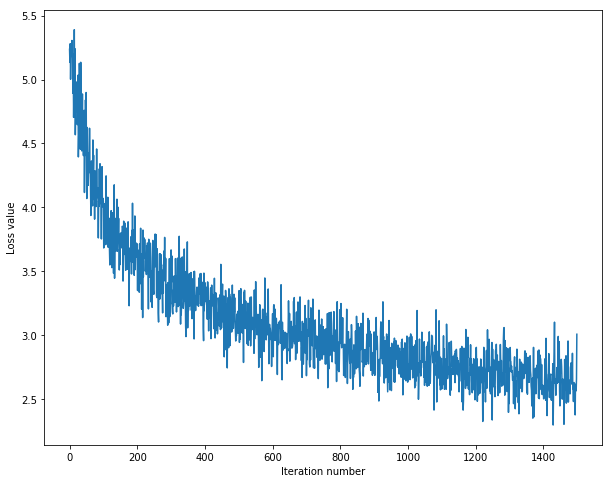

In [12]:
from cs231n.classifiers import Softmax
soft = Softmax()
tic = time.time()
loss_hist = soft.train(X_train, y_train, learning_rate=1e-7, reg=2.5e4,
                      num_iters=1500, verbose=True)


plt.plot(loss_hist)
plt.xlabel('Iteration number')
plt.ylabel('Loss value')
plt.show()

In [13]:
# Use the validation set to tune hyperparameters (regularization strength and
# learning rate). You should experiment with different ranges for the learning
# rates and regularization strengths; if you are careful you should be able to
# get a classification accuracy of over 0.35 on the validation set.
from cs231n.classifiers import Softmax
results = {}
best_val = -1
best_softmax = None
# learning_rates = [1e-7, 5e-7]
# regularization_strengths = [2.5e4, 5e4]

#learning_rates = [2e-7,1e-7,0.5e-7, 2e-6, 1e-6 ,0.5e-6,0.7e-6, 2e-7,1e-5,0.5e-5]
learning_rates= (1e-7)* np.ones((10,))
regularization_strengths = [8e6, 1e5, 2e5, 2.5e5, 4e5, 6e5,8e5,1e4 ,2e4 ,4e4]
#regularization_strengths=np.zeros((10,))

################################################################################
# TODO:                                                                        #
# Use the validation set to set the learning rate and regularization strength. #
# This should be identical to the validation that you did for the SVM; save    #
# the best trained softmax classifer in best_softmax.                          #
################################################################################
for i in range(len(learning_rates)):
    alpha=learning_rates[i]
    reg=regularization_strengths[i]
    s = Softmax()
    s.train(X_train,y_train,learning_rate=alpha, reg=reg,
            num_iters=500, verbose=True)
    y_pred = s.predict(X_train)
    train_acc= (np.mean(y_train == y_pred) )
    y_val_pred = s.predict(X_val)
    val_acc=(np.mean(y_val == y_val_pred))
    results[(alpha,reg)]=(train_acc, val_acc)
    if(val_acc>best_val):
        best_val=val_acc
        best_softmax=s
################################################################################
#                              END OF YOUR CODE                                #
################################################################################
    
# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

iteration 0 / 500: loss 244610.487172
iteration 100 / 500: loss 2.305839


iteration 200 / 500: loss 2.306159


iteration 300 / 500: loss 2.305248


iteration 400 / 500: loss 2.304748


iteration 0 / 500: loss 3121.573712


iteration 100 / 500: loss 56.804694


iteration 200 / 500: loss 3.125615


iteration 300 / 500: loss 2.228310


iteration 400 / 500: loss 2.192650


iteration 0 / 500: loss 6189.450965


iteration 100 / 500: loss 3.971886


iteration 200 / 500: loss 2.234265


iteration 300 / 500: loss 2.261950


iteration 400 / 500: loss 2.220215


iteration 0 / 500: loss 7726.304158


iteration 100 / 500: loss 2.520950


iteration 200 / 500: loss 2.216337


iteration 300 / 500: loss 2.227953


iteration 400 / 500: loss 2.257614


iteration 0 / 500: loss 12325.494481


iteration 100 / 500: loss 2.250379


iteration 200 / 500: loss 2.264677


iteration 300 / 500: loss 2.261291


iteration 400 / 500: loss 2.247468


iteration 0 / 500: loss 18520.495373


iteration 100 / 500: loss 2.277294


iteration 200 / 500: loss 2.270512


iteration 300 / 500: loss 2.288677


iteration 400 / 500: loss 2.277723


iteration 0 / 500: loss 24502.671934


iteration 100 / 500: loss 2.283808


iteration 200 / 500: loss 2.282324


iteration 300 / 500: loss 2.279064


iteration 400 / 500: loss 2.295302


iteration 0 / 500: loss 316.939053


iteration 100 / 500: loss 210.811893


iteration 200 / 500: loss 141.559906


iteration 300 / 500: loss 94.966175


iteration 400 / 500: loss 64.327965


iteration 0 / 500: loss 623.420749


iteration 100 / 500: loss 279.610392


iteration 200 / 500: loss 126.279865


iteration 300 / 500: loss 57.664876


iteration 400 / 500: loss 27.006673


iteration 0 / 500: loss 1214.966264


iteration 100 / 500: loss 244.356752


iteration 200 / 500: loss 50.519183


iteration 300 / 500: loss 11.818633


iteration 400 / 500: loss 4.050698


lr 1.000000e-07 reg 1.000000e+04 train accuracy: 0.240551 val accuracy: 0.264000


lr 1.000000e-07 reg 2.000000e+04 train accuracy: 0.299041 val accuracy: 0.308000
lr 1.000000e-07 reg 4.000000e+04 train accuracy: 0.308612 val accuracy: 0.327000
lr 1.000000e-07 reg 1.000000e+05 train accuracy: 0.295735 val accuracy: 0.309000
lr 1.000000e-07 reg 2.000000e+05 train accuracy: 0.264551 val accuracy: 0.285000
lr 1.000000e-07 reg 2.500000e+05 train accuracy: 0.276490 val accuracy: 0.283000
lr 1.000000e-07 reg 4.000000e+05 train accuracy: 0.247449 val accuracy: 0.261000
lr 1.000000e-07 reg 6.000000e+05 train accuracy: 0.244082 val accuracy: 0.261000
lr 1.000000e-07 reg 8.000000e+05 train accuracy: 0.241347 val accuracy: 0.258000
lr 1.000000e-07 reg 8.000000e+06 train accuracy: 0.190306 val accuracy: 0.194000
best validation accuracy achieved during cross-validation: 0.327000


In [14]:
# evaluate on test set
# Evaluate the best softmax on test set
y_test_pred = best_softmax.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print('softmax on raw pixels final test set accuracy: %f' % (test_accuracy, ))

softmax on raw pixels final test set accuracy: 0.324000


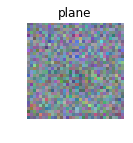

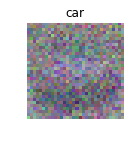

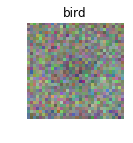

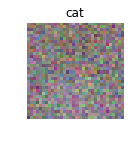

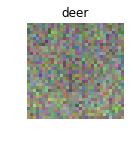

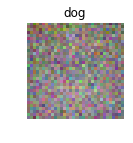

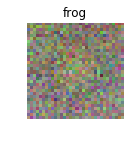

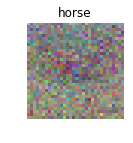

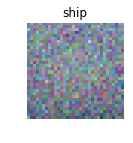

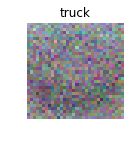

In [16]:
# Visualize the learned weights for each class
w = best_softmax.W[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 10)

w_min, w_max = np.min(w), np.max(w)

classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):
    plt.subplot(2, 5, i + 1)
    
    # Rescale the weights to be between 0 and 255
    wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])
    plt.show()